In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb

import matplotlib.pyplot as plt
from matplotlib import colors

In [18]:
from spherical_geometry.polygon import SphericalPolygon

In [2]:
!which python

/projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/bin/python


In [6]:
import lsst.log
Log = lsst.log.Log()
Log.setLevel(lsst.log.ERROR)

import lsst.daf.base
import lsst.geom as geom
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord

import lsst.afw.display
import lsst.afw.display.rgb as afwRgb

In [7]:
DATA_ROOT = '/tigress/HSC/DR/s18a_wide'

In [8]:
butler = dafPersist.Butler(DATA_ROOT)

In [9]:
skymap = butler.get('deepCoadd_skyMap', immediate=True)

In [25]:
# Jia-Xuan's example
#RA DEC
#243.88821 42.92376
#244.83857 42.25044
#236.74121 42.59723

ra, dec = 236.74121, 42.59723
radius = 20.0
pixscale = 0.168
band = 'i'
coadd_label='deepCoadd_calexp'

In [12]:
if butler is None:
    butler = lsst.daf.persistence.Butler(root)
if skymap is None:
    skymap = butler.get('deepCoadd_skyMap', immediate=True)
if type(radius) != u.Quantity:
    radius *= u.arcsec

In [17]:
size = int(radius.to('arcsec').value/pixscale)

coord = geom.SpherePoint(
    ra * geom.degrees, dec * geom.degrees)

stamp_shape = (size * 2 + 1, size * 2 + 1)

In [20]:
radec_list = np.array(sky_cone(ra, dec, radius)).T    

In [21]:
patches, patch_dict = tracts_n_patches(radec_list, skymap)

In [26]:
images = []
for t, p in patches:
    data_id = {'tract' : t, 'patch' : p.decode(), 
               'filter' : 'HSC-' + band.upper()}
    
    if butler.datasetExists(coadd_label, data_id):
        img = butler.get(coadd_label, data_id, immediate=True)
        images.append(img)

if len(images)==0:
    print('***** No data at {:.5f} {:.5f} *****'.format(ra, dec))

In [28]:
cutouts = []
idx = []
bbox_sizes = []
bbox_origins = []

for img in images:
    wcs = img.getWcs()
    pix = wcs.skyToPixel(coord)
    pix = geom.Point2I(pix)
    bbox = geom.Box2I(pix, pix)
    bbox.grow(size)
    x0, y0 = bbox.getBegin()
    bbox_origins.append([x0, y0])
    bbox.clip(img.getBBox(afwImage.PARENT))
    xnew, ynew = bbox.getBeginX() - x0, bbox.getBeginY() - y0
    idx.append([xnew, xnew + bbox.getWidth(), ynew, 
                ynew + bbox.getHeight()])
    bbox_sizes.append(bbox.getWidth() * bbox.getHeight())
    cut = img.Factory(img, bbox, afwImage.PARENT)
    cutouts.append(cut)

In [31]:
stamp_bbox = geom.BoxI(
    geom.Point2I(0,0), geom.Extent2I(*stamp_shape))

stamp = afwImage.MaskedImageF(stamp_bbox)
bbox_sorted_ind = np.argsort(bbox_sizes)

for i in bbox_sorted_ind:
    mi = cutouts[i].getMaskedImage()
    stamp[idx[i][0]: idx[i][1], idx[i][2]: idx[i][3]] = mi

In [32]:
largest_cutout = cutouts[bbox_sorted_ind[-1]]
subwcs = largest_cutout.getWcs()
crpix_1, crpix_2 = subwcs.skyToPixel(coord)
crpix_1 -= bbox_origins[bbox_sorted_ind[-1]][0] 
crpix_2 -= bbox_origins[bbox_sorted_ind[-1]][1]
cdmat = wcs.getCdMatrix()      
    
md = lsst.daf.base.PropertyList()
md.add('CRVAL1', ra)
md.add('CRVAL2', dec)
md.add('CRPIX1', crpix_1 + 1)
md.add('CRPIX2', crpix_2 + 1)
md.add('CTYPE1', 'RA---TAN')
md.add('CTYPE2', 'DEC--TAN')
md.add('CD1_1', cdmat[0, 0])
md.add('CD2_1', cdmat[1, 0])
md.add('CD1_2', cdmat[0, 1])
md.add('CD2_2', cdmat[1, 1])
md.add('RADESYS', 'ICRS')
stamp_wcs = afwGeom.makeSkyWcs(md)

stamp = afwImage.ExposureF(stamp, stamp_wcs)

In [39]:
psf_img = get_psf(largest_cutout, coord)

In [40]:
stamp.writeFits('test.fits')
psf_img.writeFits('test-psf.fits')

In [37]:
def sky_cone(ra_c, dec_c, theta, steps=50, include_center=True):
    """
    Get ra and dec coordinates of a cone on the sky.
    
    Parameters
    ----------
    ra_c, dec_c: float
        Center of cone in degrees.
    theta: astropy Quantity, float, or int
        Angular radius of cone. Must be in arcsec
        if not a Quantity object.
    steps: int, optional
        Number of steps in the cone.
    include_center: bool, optional
        If True, include center point in cone.
    
    Returns
    -------
    ra, dec: ndarry
        Coordinates of cone.
    """
    if type(theta) == float or type(theta) == int:
        theta = theta * u.arcsec
        
    cone = SphericalPolygon.from_cone(
        ra_c, dec_c, theta.to('deg').value, steps=steps)
    ra, dec = list(cone.to_lonlat())[0]
    ra = np.mod(ra - 360., 360.0)
    if include_center:
        ra = np.concatenate([ra, [ra_c]])
        dec = np.concatenate([dec, [dec_c]])
    return ra, dec


def get_psf(exp, coord):
    """Get the coadd PSF image.
    
    Parameters
    ----------
    exp: lsst.afw.image.exposure.exposure.ExposureF
        Exposure
    coord: lsst.geom.SpherePoint
        Coordinate for extracting PSF
    
    Returns
    -------
    psf_img: lsst.afw.image.image.image.ImageD
        2-D PSF image
    """
    wcs = exp.getWcs()
    if type(coord) != geom.SpherePoint:
        coord = make_afw_coords(coord)
    coord = wcs.skyToPixel(coord)
    psf = exp.getPsf()
    
    try:
        psf_img = psf.computeKernelImage(coord)
        return psf_img
    except Exception:
        print('**** Cannot compute PSF Image *****')
        return None


def make_afw_coords(coord_list):
    """
    Convert list of ra and dec to lsst.afw.coord.IcrsCoord.
    
    Parameters
    ----------
    coord_list : list of tuples or tuple
        ra and dec in degrees.
        
    Returns
    -------
    afw_coords : list of lsst.afw.coord.IcrsCoord
    """
    if type(coord_list[0]) in (float, int, np.float64):
        ra, dec = coord_list
        afw_coords = geom.SpherePoint(
            geom.Angle(ra, geom.degrees),
            geom.Angle(dec, geom.degrees))
    else:
        afw_coords = [
            geom.SpherePoint(
                geom.Angle(ra, geom.degrees),
                geom.Angle(dec, geom.degrees)) for ra, dec in coord_list]
        
    return afw_coords


def tracts_n_patches(coord_list, skymap=None, data_dir=DATA_ROOT): 
    """
    Find the tracts and patches that overlap with the 
    coordinates in coord_list. Pass the four corners of 
    a rectangle to get all tracts and patches that overlap
    with this region.
    
    Parameters
    ----------
    coord_list : list (tuples or lsst.afw.coord.IcrsCoord)
        ra and dec of region
    skymap : lsst.skymap.ringsSkyMap.RingsSkyMap, optional
        The lsst/hsc skymap. If None, it will be created.
    data_dir : string, optional
        Rerun directory. Will use name in .superbutler 
        by default.
        
    Returns
    -------
    region_ids : structured ndarray
        Tracts and patches that overlap coord_list.
    tract_patch_dict : dict
        Dictionary of dictionaries, which takes a tract 
        and patch and returns a patch info object.
    """
    if type(coord_list[0]) == float or type(coord_list[0]) == int:
        coord_list = [make_afw_coords(coord_list)]
    elif type(coord_list[0]) != geom.SpherePoint:
        coord_list = make_afw_coords(coord_list)

    if skymap is None:
        import lsst.daf.persistence
        butler = lsst.daf.persistence.Butler(data_dir)
        skymap = butler.get('deepCoadd_skyMap', immediate=True)

    tract_patch_list = skymap.findTractPatchList(coord_list)

    ids = []
    tract_patch_dict = {}
    for tract_info, patch_info_list in tract_patch_list:
        patch_info_dict = {}
        for patch_info in patch_info_list:
            patch_index = patch_info.getIndex()
            patch_id = str(patch_index[0]) + ',' + str(patch_index[1])
            ids.append((tract_info.getId(), patch_id))
            patch_info_dict.update({patch_id : patch_info})
        tract_patch_dict.update({tract_info.getId() : patch_info_dict})
        
    region_ids = np.array(ids, dtype=[('tract', int), ('patch', 'S4')])
    
    return region_ids, tract_patch_dict

In [41]:
from astropy.io import fits

In [42]:
img = fits.open('test.fits')[1].data

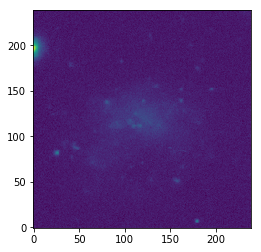

In [44]:
plt.imshow(np.arcsinh(img), interpolation='none', origin='lower')